**DATA PREPARATION**

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
import yfinance as yf
import pandas as pd

# Define your asset tickers (Yahoo Finance format)
tickers = {
    'BTC-USD': 'BTC-USD',
    'ETH-USD': 'ETH-USD',
    'EURUSD=X': 'EUR/USD',
    'JPY=X': 'USD/JPY'
}

# Set full date range
start_date = "2019-01-01"
end_date = "2025-03-31"  # Now includes validation + test periods

# Download data
data = yf.download(list(tickers.keys()), start=start_date, end=end_date)['Close']


# Rename columns for easier access
data.columns = [tickers[t] for t in data.columns]
data.dropna(inplace=True)

# Save or inspect
print(data.tail())  # See latest rows
data.to_csv("historical_data_2019_2025.csv")


[*********************100%***********************]  4 of 4 completed

                 BTC-USD      ETH-USD   EUR/USD     USD/JPY
Date                                                       
2025-03-24  87498.914062  2077.479004  1.083576  149.677002
2025-03-25  87471.703125  2067.764160  1.080357  150.774002
2025-03-26  86900.882812  2009.189331  1.078749  149.949997
2025-03-27  87177.101562  2002.357422  1.074206  150.473007
2025-03-28  84353.148438  1895.502930  1.080100  150.847000


In [ ]:
close_prices=pd.read_csv("historical_data_2019_2025.csv",index_col=0)
close_prices['JPY/USD'] = 1 / close_prices['USD/JPY']
close_prices.drop(columns='USD/JPY', inplace=True)
close_prices.to_csv("historical_data_2019_2025.csv")

In [ ]:
training_end = '2024-12-31'
validation_start = '2025-01-01'
validation_end = '2025-02-28'
testing_start = '2025-03-01'

**FEATURE ENGINEERING**

In [ ]:
def add_price_features(df, asset):
    """
    Add basic price-derived features

    Parameters:
    df (pd.DataFrame): Price data with 'close' column

    Returns:
    pd.DataFrame: DataFrame with added features
    """
    df = df.copy()

    # Price-based features
    df['returns'] = df[asset].pct_change()
    df['log_returns'] = np.log(df[asset] / df[asset].shift(1))

    # Rolling statistics
    for window in [5, 10, 20]:
        df[f'rolling_mean_{window}'] = df[asset].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[asset].rolling(window=window).std()
        df[f'rolling_min_{window}'] = df[asset].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df[asset].rolling(window=window).max()
        df[f'rolling_returns_{window}'] = df['returns'].rolling(window=window).mean()
        df[f'rolling_vol_{window}'] = df['returns'].rolling(window=window).std()

    return df

In [ ]:
def add_trend_indicators(df,asset):
    """
    Add trend indicators

    Parameters:
    df (pd.DataFrame): Price data with basic features

    Returns:
    pd.DataFrame: DataFrame with added trend indicators
    """
    df = df.copy()

    # SMA and EMA
    for window in [10, 20, 50, 200]:
        # Simple Moving Average
        df[f'sma_{window}'] = df[asset].rolling(window=window).mean()

        # Exponential Moving Average
        df[f'ema_{window}'] = df[asset].ewm(span=window, adjust=False).mean()

    # MACD (Moving Average Convergence Divergence)
    df['ema_12'] = df[asset].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df[asset].ewm(span=26, adjust=False).mean()
    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_diff'] = df['macd'] - df['macd_signal']

    return df

In [ ]:
def add_volatility_indicators(df, asset):
    """
    Add volatility indicators

    Parameters:
    df (pd.DataFrame): Price data with other indicators

    Returns:
    pd.DataFrame: DataFrame with added volatility indicators
    """
    df = df.copy()

    # Bollinger Bands
    window = 20
    df['bb_middle'] = df[asset].rolling(window=window).mean()
    df['bb_std'] = df[asset].rolling(window=window).std()
    df['bb_upper'] = df['bb_middle'] + 2 * df['bb_std']
    df['bb_lower'] = df['bb_middle'] - 2 * df['bb_std']
    df['bb_width'] = (df['bb_upper'] - df['bb_lower']) / df['bb_middle']
    df['bb_pct'] = (df[asset] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])

    # Average True Range (ATR)
    high_low = df['rolling_max_5'] - df['rolling_min_5']
    df['atr_5'] = high_low.rolling(window=5).mean()

    return df

In [ ]:
def add_momentum_indicators(df, asset):
    """
    Add momentum indicators

    Parameters:
    df (pd.DataFrame): Price data with other indicators

    Returns:
    pd.DataFrame: DataFrame with added momentum indicators
    """
    df = df.copy()

    # RSI (Relative Strength Index)
    window = 14
    delta = df[asset].diff()
    gain = delta.where(delta > 0, 0).rolling(window=window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=window).mean()

    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))

    # ROC (Rate of Change)
    for period in [5, 10, 20]:
        df[f'roc_{period}'] = df[asset].pct_change(periods=period) * 100

    return df


In [ ]:
def add_relative_indicators(df, asset):
    """
    Add relative and derived indicators

    Parameters:
    df (pd.DataFrame): Price data with other indicators

    Returns:
    pd.DataFrame: DataFrame with added relative indicators
    """
    df = df.copy()

    # Price relative to moving averages
    for window in [10, 20, 50, 200]:
        if f'sma_{window}' in df.columns:
            df[f'close_to_sma_{window}'] = df[asset] / df[f'sma_{window}'] - 1
        if f'ema_{window}' in df.columns:
            df[f'close_to_ema_{window}'] = df[asset] / df[f'ema_{window}'] - 1

    # Moving average crossovers
    if 'sma_10' in df.columns and 'sma_20' in df.columns:
        df['sma_10_20_cross'] = np.where(df['sma_10'] > df['sma_20'], 1, -1)
    if 'sma_20' in df.columns and 'sma_50' in df.columns:
        df['sma_20_50_cross'] = np.where(df['sma_20'] > df['sma_50'], 1, -1)
    if 'sma_50' in df.columns and 'sma_200' in df.columns:
        df['sma_50_200_cross'] = np.where(df['sma_50'] > df['sma_200'], 1, -1)

    return df

In [ ]:
def create_target(df, asset, prediction_horizon=1):
    """
    Create target variable for prediction

    Parameters:
    df (pd.DataFrame): Price data with features
    prediction_horizon (int): Number of periods ahead to predict

    Returns:
    pd.DataFrame: DataFrame with target variable
    """
    df = df.copy()

    # Target variable: future returns
    #What is the percentage change from today to t + prediction_horizon (e.g., tomorrow)?
    df['future_returns'] = df[asset].pct_change(periods=prediction_horizon).shift(-prediction_horizon)
    df['target'] = np.where(df['future_returns'] > 0, 1, 0)  # 1 for up, 0 for down

    return df

In [ ]:
def engineer_features(df, asset, prediction_horizon=1):
    """
    Complete feature engineering pipeline

    Parameters:
    df (pd.DataFrame): Asset price data with 'close' column
    historical_data (pd.DataFrame): Historical data with all assets (optional)
    prediction_horizon (int): Number of periods ahead to predict

    Returns:
    pd.DataFrame: DataFrame with all features and target
    """
    df = add_price_features(df, asset)
    df = add_trend_indicators(df, asset)
    df = add_volatility_indicators(df, asset)
    df = add_momentum_indicators(df, asset)
    df = add_relative_indicators(df, asset)

    df = create_target(df, asset, prediction_horizon)

    # Drop NaN values
    df.dropna(inplace=True)

    return df

In [ ]:
def prepare_target_feature_data(df, asset):
    """
    Prepare data for target and feature

    Parameters:
    df (pd.DataFrame): Data with features and target


    Returns:
    tuple: X_train, X_test, y_train, y_test
    """
    # Define features and target
    features = [col for col in df.columns if col not in [asset, 'future_returns', 'target']]
    X = df[features]
    y = df['target']

    return X, y

**model building with tuning**

In [ ]:
def tune_xgboost_hyperparameters(X_train, y_train, X_val, y_val):
    """
    Tune XGBoost hyperparameters using grid search with validation data

    Parameters:
    X_train (pd.DataFrame): Training features
    y_train (pd.Series): Training target
    X_val (pd.DataFrame): Validation features
    y_val (pd.Series): Validation target

    Returns:
    dict: Best parameters found
    """
    import xgboost as xgb
    from sklearn.metrics import accuracy_score, f1_score
    import itertools
    import numpy as np

    print("Tuning XGBoost hyperparameters...")

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [ 0.05, 0.1,0.15],
        'subsample': [ 0.8, 0.9],
        'colsample_bytree': [ 0.8, 0.9],
    }

    # For efficiency, we'll use a reduced grid search approach
    # Alternatively, you could use sklearn's GridSearchCV but that can be very slow
    best_score = 0
    best_params = None

    # Get selected parameter combinations (for efficiency, not all combinations)
    n_estimators_options = param_grid['n_estimators']
    max_depth_options = param_grid['max_depth']
    learning_rate_options = param_grid['learning_rate']

    # First pass: try key parameters
    for n_est, depth, lr in itertools.product(n_estimators_options, max_depth_options, learning_rate_options):
        params = {
            'n_estimators': n_est,
            'max_depth': depth,
            'learning_rate': lr,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42
        }

        # Train model
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train)

        # Evaluate on validation set
        y_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_pred)

        print(f"Params: n_est={n_est}, depth={depth}, lr={lr} → F1 Score: {f1:.4f}")

        if f1 > best_score:
            best_score = f1
            best_params = params

    # Second pass: refine best parameters with more options
    if best_params:
        subsample_options = param_grid['subsample']
        colsample_options = param_grid['colsample_bytree']

        for subsample, colsample in itertools.product(subsample_options, colsample_options):
            params = best_params.copy()
            params['subsample'] = subsample
            params['colsample_bytree'] = colsample

            # Train model
            model = xgb.XGBClassifier(**params)
            model.fit(X_train, y_train)

            # Evaluate on validation set
            y_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_pred)

            print(f"Refined - subsample={subsample}, colsample={colsample} → F1 Score: {f1:.4f}")

            if f1 > best_score:
                best_score = f1
                best_params = params

    print(f"Best parameters found with F1 Score: {best_score:.4f}")
    print(best_params)

    return best_params

In [ ]:
# xgboosting with feature selections
def train_xgboost_model(X_train, y_train, params=None, top_n_features=20):
    """
    Train an XGBoost classification model with optional top-N feature selection by gain

    Parameters:
    X_train (pd.DataFrame): Training features
    y_train (pd.Series): Training target
    params (dict): XGBoost parameters
    top_n_features (int): Number of top features to select based on gain

    Returns:
    tuple: Trained model, DataFrame of feature importances, List of selected features
    """

    if params is None:
        params = {
            'n_estimators': 100,
            'max_depth': 5,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'random_state': 42
        }

    # Train full model
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Get feature importance by 'gain'
    booster = model.get_booster()
    gain_scores = booster.get_score(importance_type='gain')
    importance_df = pd.DataFrame.from_dict(gain_scores, orient='index', columns=['gain'])
    importance_df = importance_df.sort_values(by='gain', ascending=False).reset_index()
    importance_df.columns = ['feature', 'gain']

    # Optional: limit to top-N features
    selected_features = X_train.columns.tolist()
    if top_n_features is not None:
        selected_features = importance_df['feature'].head(top_n_features).tolist()

        # Retrain model on top-N features
        model = xgb.XGBClassifier(**params)
        model.fit(X_train[selected_features], y_train)

    return model, importance_df, selected_features


In [ ]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data

    Parameters:
    model (xgb.XGBClassifier): Trained model
    X_test (pd.DataFrame): Test features
    y_test (pd.Series): Test target

    Returns:
    dict: Evaluation metrics
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

    return metrics

In [ ]:
def tune_signal_thresholds(model, val_df, asset_column, selected_features, starting_capital=10000):
    """
    Tune buy/sell thresholds to optimize strategy performance on validation data

    Parameters:
    model (xgb.XGBClassifier): Trained model
    val_df (pd.DataFrame): Validation dataframe with features
    asset_column (str): Asset column name
    selected_features (list): Selected features for prediction
    starting_capital (float): Starting capital for simulation

    Returns:
    list: Optimal [buy_threshold, sell_threshold]
    """
    from itertools import product

    print("Tuning signal thresholds...")

    # Define threshold search space
    buy_thresholds = [ 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ]
    sell_thresholds = [ 0.35, 0.34, 0.33, 0.32, 0.31, 0.3 ]

    best_sharpe = -float('inf')
    best_thresholds = None
    results = []

    # Test all combinations
    for buy_threshold, sell_threshold in product(buy_thresholds, sell_thresholds):
        if sell_threshold >= buy_threshold:
            continue  # Invalid configuration: sell threshold should be lower than buy

        thresholds = [buy_threshold, sell_threshold]

        # Generate raw signals
        raw_signals = generate_signals(model, val_df, asset_column, selected_features, thresholds)

        # Apply position management (simplified for faster tuning)
        signals = hybrid_position_management(
            raw_signals, asset_column, max_hold_days=5,
            trailing_stop_pct=0.02,
            starting_capital=starting_capital
        )

        # Calculate performance metrics
        final_value = signals['portfolio_value'].iloc[-1]
        total_return = (final_value / starting_capital - 1) * 100

        if len(signals) > 1:
            daily_returns = signals['portfolio_value'].pct_change().dropna()
            if len(daily_returns) > 0:
                ann_return = total_return * (252 / len(signals))
                ann_vol = daily_returns.std() * np.sqrt(252) * 100
                sharpe = ann_return / ann_vol if ann_vol > 0 else 0
                max_dd = (signals['portfolio_value'] / signals['portfolio_value'].cummax() - 1).min() * 100

                result = {
                    'buy_threshold': buy_threshold,
                    'sell_threshold': sell_threshold,
                    'return': total_return,
                    'sharpe': sharpe,
                    'max_drawdown': max_dd
                }

                results.append(result)

                print(f"Thresholds [Buy={buy_threshold}, Sell={sell_threshold}] → "
                      f"Return: {total_return:.2f}%, Sharpe: {sharpe:.2f}, MaxDD: {max_dd:.2f}%")

                # We optimize for Sharpe ratio
                if sharpe > best_sharpe:
                    best_sharpe = sharpe
                    best_thresholds = thresholds

    if best_thresholds:
        print(f"\nBest thresholds found: Buy={best_thresholds[0]}, Sell={best_thresholds[1]}")
        print(f"Best Sharpe ratio: {best_sharpe:.2f}")
    else:
        # Default thresholds if optimization fails
        best_thresholds = [0.7, 0.3]
        print("Threshold optimization did not find better values, using defaults.")

    return best_thresholds

**Signal Generation + Position Management**


In [ ]:

#we assume that real time trading model will take the close price which in this case is are reference price shortly before the real close
def generate_signals(model, df, asset, selected_features, thresholds):
    """
    Generate raw trading signals based on model predictions without portfolio management
     signal + investment amount

    Parameters:
    model (xgb.XGBClassifier): Trained model
    df (pd.DataFrame): Data with features
    asset (str): Asset column name
    selected_features (list): Features to use for prediction
    thresholds (list): [buy_threshold, sell_threshold]

    Returns:
    pd.DataFrame: DataFrame with signal probabilities and raw signals
    """
    df_signals = df.copy()
    buy_threshold = thresholds[0]
    sell_threshold = thresholds[1]

    # Generate predictions using selected features
    X = df[selected_features]
    df_signals['signal_prob'] = model.predict_proba(X)[:, 1] #using tdy's x to predict t+1 buying P

    # Initialize signal column to 0 (hold)
    df_signals['signal'] = 0

    # Generate signals based on thresholds
    df_signals.loc[df_signals['signal_prob'] > buy_threshold, 'signal'] = 1   # Buy
    df_signals.loc[df_signals['signal_prob'] < sell_threshold, 'signal'] = -1  # Sell

    # Determine investment amount based on signal confidence
    df_signals['investment'] = 0

    # Standard investment amount for normal signals
    df_signals.loc[(df_signals['signal_prob'] > buy_threshold) &
                  (df_signals['signal_prob'] <= 0.8), 'investment'] = 3000
    df_signals.loc[(df_signals['signal_prob'] < sell_threshold) &
                  (df_signals['signal_prob'] >= 0.2), 'investment'] = 3000

    # Higher investment amount for high-conviction signals
    df_signals.loc[df_signals['signal_prob'] > 0.8, 'investment'] = 6000
    df_signals.loc[df_signals['signal_prob'] < 0.2, 'investment'] = 6000

    # Include price and returns
    df_signals['returns'] = df_signals[asset].pct_change() #row: current day signal(based on future  --> t+1 day returns

    return df_signals[[asset, 'returns', 'signal_prob', 'signal', 'investment']]

def hybrid_position_management(signals_df, asset_column, max_hold_days=5, trailing_stop_pct=0.02, starting_capital=10000):
    """
    Apply hybrid position management logic with support for both long and short positions
    take the raw signals

    Parameters:
    signals_df (pd.DataFrame): DataFrame with raw trading signals (from generate_signals)
    asset_column (str): Name of the asset column
    max_hold_days (int): Maximum days to hold any position (5 days)
    trailing_stop_pct (float): Close if position drops this % from highest point (for longs)
                               or rises this % from lowest point (for shorts)
    starting_capital (float): Initial capital amount

    Returns:
    pd.DataFrame: Updated signals dataframe with position management
    """
    import numpy as np

    signals = signals_df.copy()


    # Add columns to track position
    signals['position_age'] = 0
    signals['highest_point'] = 0  # For long positions
    signals['lowest_point'] = 0   # For short positions
    signals['trailing_stop'] = 0
    signals['position_size_pct'] = 1.0  # Full size at entry
    signals['position_type'] = 'none'  # 'long', 'short', or 'none'
    signals['exit_reason'] = ''

    # Initialize portfolio tracking
    signals['cash'] = starting_capital
    signals['position_value'] = 0
    signals['portfolio_value'] = starting_capital

    # Iterate through the time series
    for i in range(1, len(signals)):
        prev_idx = signals.index[i-1]
        curr_idx = signals.index[i]

        # Get signal and price information
        curr_price = signals.loc[curr_idx, asset_column]
        prev_price = signals.loc[prev_idx, asset_column]
        price_change = curr_price / prev_price - 1  # Daily return--->t price compared with t-1 price

        # Get previous position info
        prev_cash = signals.loc[prev_idx, 'cash']
        prev_position_value = signals.loc[prev_idx, 'position_value']
        prev_position_type = signals.loc[prev_idx, 'position_type']
        prev_age = signals.loc[prev_idx, 'position_age']

        # Get current signal
        curr_signal = signals.loc[curr_idx, 'signal']
        investment = signals.loc[curr_idx, 'investment']

        # Default to carrying forward the previous state
        new_cash = prev_cash
        new_position_value = prev_position_value
        new_position_type = prev_position_type
        new_age = prev_age
        exit_reason = ''

        # Update values based on price change
        if prev_position_type == 'long':
            # Long positions increase in value when price goes up
            new_position_value = prev_position_value * (1 + price_change)
            # Update highest seen price for trailing stop
            prev_highest = signals.loc[prev_idx, 'highest_point']
            new_highest = max(prev_highest, new_position_value) if prev_highest > 0 else new_position_value #highest asset value held
            signals.loc[curr_idx, 'highest_point'] = new_highest

            # Calculate trailing stop level for long positions
            stop_level = new_highest * (1 - trailing_stop_pct)

        elif prev_position_type == 'short':
            # Short positions increase in value when price goes down (negative correlation)
            new_position_value = prev_position_value * (1 - price_change)
            # Update lowest seen price for trailing stop (for shorts)
            prev_lowest = signals.loc[prev_idx, 'lowest_point']
            new_lowest = min(prev_lowest, new_position_value) if prev_lowest > 0 else new_position_value
            signals.loc[curr_idx, 'lowest_point'] = new_lowest

            # Calculate trailing stop level for short positions
            stop_level = new_lowest * (1 + trailing_stop_pct) if new_lowest > 0 else 0

        # Check exit conditions if we have an open position
        if prev_position_type != 'none':
            # Increment position age
            new_age = prev_age + 1


            # Check exit conditions
            exit_position = False

            # 1. Maximum hold period reached (5 days)
            if new_age >= max_hold_days:
                exit_position = True
                exit_reason = "max_hold_5d"

            # 2. Trailing stop triggered
            elif ((prev_position_type == 'long' and new_position_value < stop_level and signals.loc[prev_idx, 'highest_point'] > 0) or
                  (prev_position_type == 'short' and new_position_value < stop_level and signals.loc[prev_idx, 'lowest_point'] > 0)):
                exit_position = True
                exit_reason = "stop_loss"

            # 3. Signal reversed
            elif (prev_position_type == 'long' and curr_signal < 0) or (prev_position_type == 'short' and curr_signal > 0):
                exit_position = True
                exit_reason = "signal_reversed"

            # Apply exit if needed
            if exit_position:
                # Close position and add value to cash
                new_cash = prev_cash + new_position_value
                new_position_value = 0
                new_position_type = 'none'
                new_age = 0
                signals.loc[curr_idx, 'highest_point'] = 0
                signals.loc[curr_idx, 'lowest_point'] = 0
                signals.loc[curr_idx, 'exit_reason'] = exit_reason

        # Check for new entry conditions if we have no position or just exited
        if new_position_type == 'none' and curr_signal != 0:
            # Ensure we have enough cash to invest
            investment = min(investment, new_cash)

            if curr_signal > 0:  # Buy signal
                new_cash -= investment
                new_position_value = investment
                new_position_type = 'long'
                new_age = 0
                signals.loc[curr_idx, 'highest_point'] = new_position_value

            elif curr_signal < 0:  # Sell/short signal
                new_cash -= investment  # Set aside collateral
                new_position_value = investment
                new_position_type = 'short'
                new_age = 0
                signals.loc[curr_idx, 'lowest_point'] = new_position_value

        # Update the state for the current day
        signals.loc[curr_idx, 'cash'] = new_cash
        signals.loc[curr_idx, 'position_value'] = new_position_value
        signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
        signals.loc[curr_idx, 'position_type'] = new_position_type
        signals.loc[curr_idx, 'position_age'] = new_age

    # Calculate daily P&L
    signals['daily_pnl'] = signals['portfolio_value'].diff()
    signals['cumulative_pnl'] = signals['portfolio_value'] - starting_capital

    return signals

def plot_hybrid_strategy(signals, asset_name, starting_capital=10000):
    """
    Plot asset price, signals, and performance metrics for the hybrid position management

    Parameters:
    signals (pd.DataFrame): DataFrame with trading signals and portfolio metrics
    asset_name (str): Asset name for the plot title
    starting_capital (float): Starting portfolio value
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.dates import DateFormatter
    import pandas as pd

    fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14, 16), sharex=True)

    # Convert index to datetime if it's not already
    if not isinstance(signals.index, pd.DatetimeIndex):
        signals.index = pd.to_datetime(signals.index)

    # Plot 1: Asset price with entry/exit points
    ax1.plot(signals.index, signals[asset_name], label='Price', color='gray', alpha=0.7)

    # Mark long entries
    long_entries = signals[(signals['position_type'] == 'long') & (signals['position_age'] == 0)]
    ax1.scatter(long_entries.index, long_entries[asset_name], marker='^', color='green', s=100, label='Long Entry')

    # Mark short entries
    short_entries = signals[(signals['position_type'] == 'short') & (signals['position_age'] == 0)]
    ax1.scatter(short_entries.index, short_entries[asset_name], marker='v', color='red', s=100, label='Short Entry')

    # Mark position exits
    exits = signals[signals['exit_reason'] != '']

    # Color exits based on reason
    for reason in exits['exit_reason'].unique():
        reason_exits = exits[exits['exit_reason'] == reason]
        ax1.scatter(reason_exits.index, reason_exits[asset_name],
                   marker='X', s=80, label=f'Exit: {reason}')

    ax1.set_title(f'{asset_name} Price with Hybrid Position Management (Max Hold: 5 days)', fontsize=15)
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Format date on x-axis
    date_format = DateFormatter('%Y-%m-%d')
    ax1.xaxis.set_major_formatter(date_format)



    # Plot 2: Portfolio value
    ax2.plot(signals.index, signals['portfolio_value'], label='Portfolio Value', color='blue')
    ax2.axhline(y=starting_capital, color='black', linestyle='--', alpha=0.5, label='Starting Capital')

    # Shade background based on position type
    for i in range(len(signals)-1):
        start = signals.index[i]
        end = signals.index[i+1]
        if signals['position_type'][i] == 'long':
            ax2.axvspan(start, end, color='green', alpha=0.1)
        elif signals['position_type'][i] == 'short':
            ax2.axvspan(start, end, color='red', alpha=0.1)

    ax2.set_title('Portfolio Value Over Time', fontsize=15)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Value ($)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Calculate and display key metrics
    final_value = signals['portfolio_value'].iloc[-1]
    total_return = (final_value / starting_capital - 1) * 100

    # Display key metrics on the plot
    metrics_text = (
        f"Initial Capital: ${starting_capital:,.2f}\n"
        f"Final Portfolio: ${final_value:,.2f}\n"
        f"Total Return: {total_return:.2f}%\n"
    )

    # Calculate additional metrics
    if len(signals) > 1:
        daily_returns = signals['portfolio_value'].pct_change().dropna()
        if len(daily_returns) > 0:
            ann_return = total_return * (252 / len(signals))
            ann_vol = daily_returns.std() * np.sqrt(252) * 100
            sharpe = ann_return / ann_vol if ann_vol > 0 else 0
            max_dd = (signals['portfolio_value'] / signals['portfolio_value'].cummax() - 1).min() * 100

            metrics_text += (
                f"Annualized Return: {ann_return:.2f}%\n"
                f"Annualized Vol: {ann_vol:.2f}%\n"
                f"Sharpe Ratio: {sharpe:.2f}\n"
                f"Max Drawdown: {max_dd:.2f}%"
            )

    # Add metrics textbox
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax2.text(0.02, 0.05, metrics_text, transform=ax2.transAxes, fontsize=10,
            verticalalignment='bottom', bbox=props)

    plt.tight_layout()
    plt.show()



**Metrics Calculation**

In [ ]:
def calculate_enhanced_metrics(strategy_results, starting_capital=10000):
    """
    Calculate key performance metrics for a trading strategy

    Parameters:
    strategy_results (pd.DataFrame): DataFrame with strategy results including portfolio_value
    starting_capital (float): Initial capital amount

    Returns:
    dict: Dictionary of calculated metrics
    """
    import pandas as pd
    import numpy as np

    # Initialize metrics dictionary
    metrics = {}

    # Basic portfolio metrics
    final_value = strategy_results['portfolio_value'].iloc[-1]
    total_return = (final_value / starting_capital - 1) * 100
    metrics['total_return'] = total_return
    metrics['final_value'] = final_value

    # Count trades
    metrics['num_trades'] = strategy_results['exit_reason'].apply(lambda x: isinstance(x, str) and x.strip() != '').sum()

    # Calculate average profit per trade
    if metrics['num_trades'] > 0:
        metrics['avg_profit_per_trade'] = (final_value - starting_capital) / metrics['num_trades']
    else:
        metrics['avg_profit_per_trade'] = 0

    # Returns-based metrics
    if len(strategy_results) > 1:
        daily_returns = strategy_results['portfolio_value'].pct_change().dropna()

        if len(daily_returns) > 0:
            # Annualized return
            metrics['ann_return'] = total_return * (252 / len(strategy_results))

            # Annualized volatility
            metrics['ann_vol'] = daily_returns.std() * np.sqrt(252) * 100

            # Sharpe ratio
            metrics['sharpe_ratio'] = metrics['ann_return'] / metrics['ann_vol'] if metrics['ann_vol'] > 0 else 0

            # Maximum drawdown
            metrics['max_drawdown'] = (strategy_results['portfolio_value'] / strategy_results['portfolio_value'].cummax() - 1).min() * 100
    else:
        metrics['ann_return'] = 0
        metrics['ann_vol'] = 0
        metrics['sharpe_ratio'] = 0
        metrics['max_drawdown'] = 0

    return metrics

def print_performance_report(metrics):
    """
    Print a formatted performance report with only key metrics

    Parameters:
    metrics (dict): Dictionary of calculated metrics
    """
    print("\n" + "="*50)
    print(" "*15 + "KEY PERFORMANCE METRICS")
    print("="*50)

    print(f"Annual Return: {metrics['ann_return']:.2f}%")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2f}%")
    print(f"Annual Volatility: {metrics['ann_vol']:.2f}%")
    print(f"Number of Trades: {metrics['num_trades']}")
    print(f"Profit per Trade: ${metrics['avg_profit_per_trade']:.2f}")

    print("="*50)

**Backtesting **

In [ ]:
def backtest_hybrid_strategy_with_tuning(historical_data, asset_column,
                                      starting_capital=10000,
                                      max_hold_days=5, trailing_stop_pct=0.02,
                                      prediction_horizon=1, top_n_features=20):
    """
    Complete trading pipeline with hyperparameter tuning, hybrid position management,
    and enhanced performance metrics

    Parameters:
    historical_data (pd.DataFrame): Historical data with all assets
    asset_column (str): Column name for the asset (e.g., 'BTC-USD')
    starting_capital (float): Starting portfolio value
    max_hold_days (int): Maximum days to hold any position
    trailing_stop_pct (float): Trailing stop percentage
    prediction_horizon (int): Number of periods ahead to predict
    top_n_features (int): Number of top features to use

    Returns:
    dict: Dictionary with results
    """
    import pandas as pd
    import numpy as np

    print(f"Processing {asset_column} with automated hyperparameter tuning...")

    # 1. Prepare data for this asset
    asset_data = historical_data[[asset_column]]

    # 2. Engineer features
    print("Engineering features...")
    data_with_features = engineer_features(asset_data, asset_column, prediction_horizon)

    # 3. Prepare train/validation/test data
    print("Preparing data splits...")
    train_df = data_with_features.loc[:training_end]
    val_df = data_with_features.loc[validation_start:validation_end]
    test_df = data_with_features.loc[testing_start:]

    X_train, y_train = prepare_target_feature_data(train_df, asset_column)
    X_val, y_val = prepare_target_feature_data(val_df, asset_column)
    X_test, y_test = prepare_target_feature_data(test_df, asset_column)

    # 4. Tune XGBoost model hyperparameters
    best_params = tune_xgboost_hyperparameters(X_train, y_train, X_val, y_val)

    # 5. Train model with best parameters
    print("Training XGBoost model with tuned parameters...")
    model, feature_importance, selected_features = train_xgboost_model(
        X_train, y_train, params=best_params, top_n_features=top_n_features
    )

    # 6. Evaluate model accuracy
    y_val_pred = model.predict(X_val[selected_features])
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation accuracy: {val_accuracy:.4f}")

    # 7. Tune signal thresholds
    best_thresholds = tune_signal_thresholds(
        model, val_df, asset_column, selected_features, starting_capital
    )

    # 8. Generate signals for test set using best parameters
    print("Generating trading signals with optimized thresholds...")
    raw_signals = generate_signals(model, test_df, asset_column, selected_features, best_thresholds)

    # 9. Apply hybrid position management
    print("Applying hybrid position management...")

    strategy_results = hybrid_position_management(
        raw_signals, asset_column, max_hold_days, trailing_stop_pct, starting_capital=starting_capital
    )


    # 10. Calculate enhanced performance metrics
    print("Calculating comprehensive performance metrics...")
    metrics = calculate_enhanced_metrics(strategy_results, starting_capital)

    # 11. Print performance report
    print_performance_report(metrics)

    # 12. Visualize results
    print("Generating visualizations...")
    plot_hybrid_strategy(strategy_results, asset_column, starting_capital)


    return {
        'model': model,
        'best_params': best_params,
        'best_thresholds': best_thresholds,
        'feature_importance': feature_importance,
        'signals': strategy_results,
        'selected_features': selected_features,
        'validation_accuracy': val_accuracy,
        'metrics': metrics  # Include all calculated metrics in return value
    }

Processing ETH-USD with automated hyperparameter tuning...
Engineering features...
Preparing data splits...
Tuning XGBoost hyperparameters...
Params: n_est=50, depth=3, lr=0.05 → F1 Score: 0.3429
Params: n_est=50, depth=3, lr=0.1 → F1 Score: 0.4390
Params: n_est=50, depth=3, lr=0.15 → F1 Score: 0.4615
Params: n_est=50, depth=5, lr=0.05 → F1 Score: 0.2857
Params: n_est=50, depth=5, lr=0.1 → F1 Score: 0.5000
Params: n_est=50, depth=5, lr=0.15 → F1 Score: 0.4211
Params: n_est=50, depth=7, lr=0.05 → F1 Score: 0.4103
Params: n_est=50, depth=7, lr=0.1 → F1 Score: 0.4000
Params: n_est=50, depth=7, lr=0.15 → F1 Score: 0.3429
Params: n_est=100, depth=3, lr=0.05 → F1 Score: 0.3030
Params: n_est=100, depth=3, lr=0.1 → F1 Score: 0.4000
Params: n_est=100, depth=3, lr=0.15 → F1 Score: 0.2941
Params: n_est=100, depth=5, lr=0.05 → F1 Score: 0.4000
Params: n_est=100, depth=5, lr=0.1 → F1 Score: 0.3784
Params: n_est=100, depth=5, lr=0.15 → F1 Score: 0.4390
Params: n_est=100, depth=7, lr=0.05 → F1 Score:

<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-

Thresholds [Buy=0.65, Sell=0.32] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.65, Sell=0.31] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.65, Sell=0.3] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3044.567996672805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = new_highest
<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540d

Thresholds [Buy=0.66, Sell=0.35] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.66, Sell=0.34] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.66, Sell=0.33] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3044.567996672805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = new_highest
<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540d

Thresholds [Buy=0.66, Sell=0.32] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.66, Sell=0.31] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.66, Sell=0.3] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3044.567996672805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = new_highest
<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540d

Thresholds [Buy=0.67, Sell=0.35] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.67, Sell=0.34] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.67, Sell=0.33] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.67, Sell=0.32] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-

Thresholds [Buy=0.67, Sell=0.31] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.67, Sell=0.3] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.68, Sell=0.35] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.68, Sell=0.34] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-

Thresholds [Buy=0.68, Sell=0.33] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.68, Sell=0.32] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.68, Sell=0.31] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.68, Sell=0.3] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3249.7150620390357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3044.567996672805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] =

Thresholds [Buy=0.69, Sell=0.35] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.69, Sell=0.34] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.69, Sell=0.33] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-

Thresholds [Buy=0.69, Sell=0.32] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.69, Sell=0.31] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.69, Sell=0.3] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-

Thresholds [Buy=0.7, Sell=0.35] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.7, Sell=0.34] → Return: 4.30%, Sharpe: 1.87, MaxDD: -2.92%
Thresholds [Buy=0.7, Sell=0.33] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-

Thresholds [Buy=0.7, Sell=0.32] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.7, Sell=0.31] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%
Thresholds [Buy=0.7, Sell=0.3] → Return: -1.77%, Sharpe: -1.18, MaxDD: -4.01%

Best thresholds found: Buy=0.65, Sell=0.35
Best Sharpe ratio: 1.87
Generating trading signals with optimized thresholds...
Applying hybrid position management...
Calculating comprehensive performance metrics...

               KEY PERFORMANCE METRICS
Annual Return: 14.36%
Sharpe Ratio: 1.30
Max Drawdown: -1.19%
Annual Volatility: 11.08%
Number of Trades: 3
Profit per Trade: $36.10
Generating visualizations...


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2930.4288465758095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9930.428846575809' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-

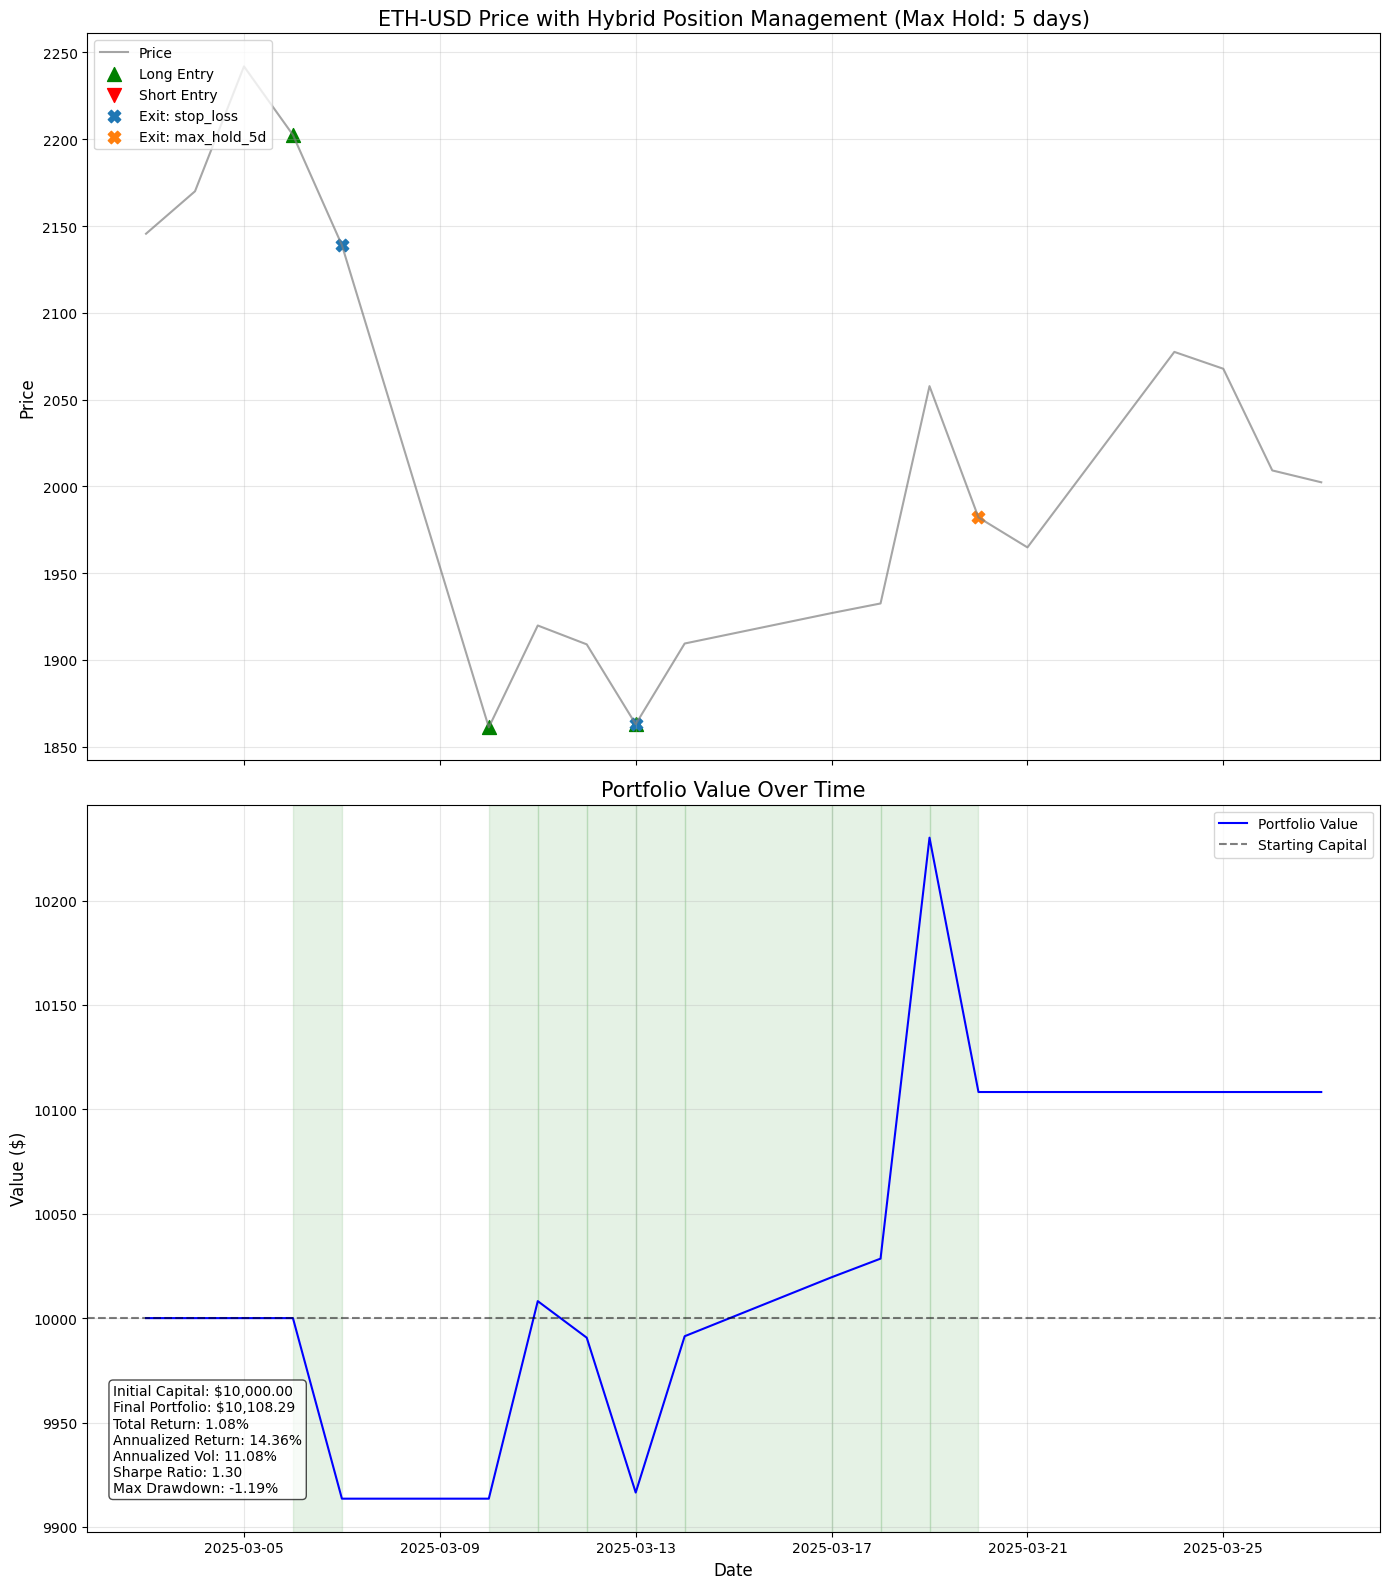

In [ ]:
ETH = backtest_hybrid_strategy_with_tuning(
    close_prices,           # Your historical price data
    'ETH-USD',              # The asset you want to trade
    max_hold_days=5,        # Maximum hold period of 5 days
    trailing_stop_pct=0.02)

Processing BTC-USD with automated hyperparameter tuning...
Engineering features...
Preparing data splits...
Tuning XGBoost hyperparameters...
Params: n_est=50, depth=3, lr=0.05 → F1 Score: 0.3529
Params: n_est=50, depth=3, lr=0.1 → F1 Score: 0.4242
Params: n_est=50, depth=3, lr=0.15 → F1 Score: 0.3429
Params: n_est=50, depth=5, lr=0.05 → F1 Score: 0.3333
Params: n_est=50, depth=5, lr=0.1 → F1 Score: 0.4000
Params: n_est=50, depth=5, lr=0.15 → F1 Score: 0.3125
Params: n_est=50, depth=7, lr=0.05 → F1 Score: 0.5000
Params: n_est=50, depth=7, lr=0.1 → F1 Score: 0.4571
Params: n_est=50, depth=7, lr=0.15 → F1 Score: 0.4000
Params: n_est=100, depth=3, lr=0.05 → F1 Score: 0.3871
Params: n_est=100, depth=3, lr=0.1 → F1 Score: 0.4118
Params: n_est=100, depth=3, lr=0.15 → F1 Score: 0.4571
Params: n_est=100, depth=5, lr=0.05 → F1 Score: 0.3030
Params: n_est=100, depth=5, lr=0.1 → F1 Score: 0.4000
Params: n_est=100, depth=5, lr=0.15 → F1 Score: 0.2500
Params: n_est=100, depth=7, lr=0.05 → F1 Score:

<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.65, Sell=0.34] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%
Thresholds [Buy=0.65, Sell=0.33] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.65, Sell=0.32] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%
Thresholds [Buy=0.65, Sell=0.31] → Return: 6.28%, Sharpe: 1.80, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.65, Sell=0.3] → Return: 6.28%, Sharpe: 1.80, MaxDD: -3.70%
Thresholds [Buy=0.66, Sell=0.35] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.66, Sell=0.34] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%
Thresholds [Buy=0.66, Sell=0.33] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.66, Sell=0.32] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%
Thresholds [Buy=0.66, Sell=0.31] → Return: 6.28%, Sharpe: 1.80, MaxDD: -3.70%
Thresholds [Buy=0.66, Sell=0.3] → Return: 6.28%, Sharpe: 1.80, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.67, Sell=0.35] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%
Thresholds [Buy=0.67, Sell=0.34] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.67, Sell=0.33] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%
Thresholds [Buy=0.67, Sell=0.32] → Return: 5.06%, Sharpe: 1.43, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.67, Sell=0.31] → Return: 6.28%, Sharpe: 1.80, MaxDD: -3.70%
Thresholds [Buy=0.67, Sell=0.3] → Return: 6.28%, Sharpe: 1.80, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.68, Sell=0.35] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%
Thresholds [Buy=0.68, Sell=0.34] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.68, Sell=0.33] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%
Thresholds [Buy=0.68, Sell=0.32] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.68, Sell=0.31] → Return: 6.00%, Sharpe: 1.72, MaxDD: -3.70%
Thresholds [Buy=0.68, Sell=0.3] → Return: 6.00%, Sharpe: 1.72, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.69, Sell=0.35] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%
Thresholds [Buy=0.69, Sell=0.34] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.69, Sell=0.33] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%
Thresholds [Buy=0.69, Sell=0.32] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.69, Sell=0.31] → Return: 6.00%, Sharpe: 1.72, MaxDD: -3.70%
Thresholds [Buy=0.69, Sell=0.3] → Return: 6.00%, Sharpe: 1.72, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.7, Sell=0.35] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%
Thresholds [Buy=0.7, Sell=0.34] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.7, Sell=0.33] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%
Thresholds [Buy=0.7, Sell=0.32] → Return: 4.79%, Sharpe: 1.35, MaxDD: -3.70%
Thresholds [Buy=0.7, Sell=0.31] → Return: 6.00%, Sharpe: 1.72, MaxDD: -3.70%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3878.5823990298904' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9878.58239902989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.7, Sell=0.3] → Return: 6.00%, Sharpe: 1.72, MaxDD: -3.70%

Best thresholds found: Buy=0.65, Sell=0.31
Best Sharpe ratio: 1.80
Generating trading signals with optimized thresholds...
Applying hybrid position management...
Calculating comprehensive performance metrics...

               KEY PERFORMANCE METRICS
Annual Return: 33.61%
Sharpe Ratio: 1.41
Max Drawdown: -2.14%
Annual Volatility: 23.86%
Number of Trades: 7
Profit per Trade: $36.20
Generating visualizations...


<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4021.9093992525395' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10021.90939925254' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6330.836673266948' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = new_highest
<ipytho

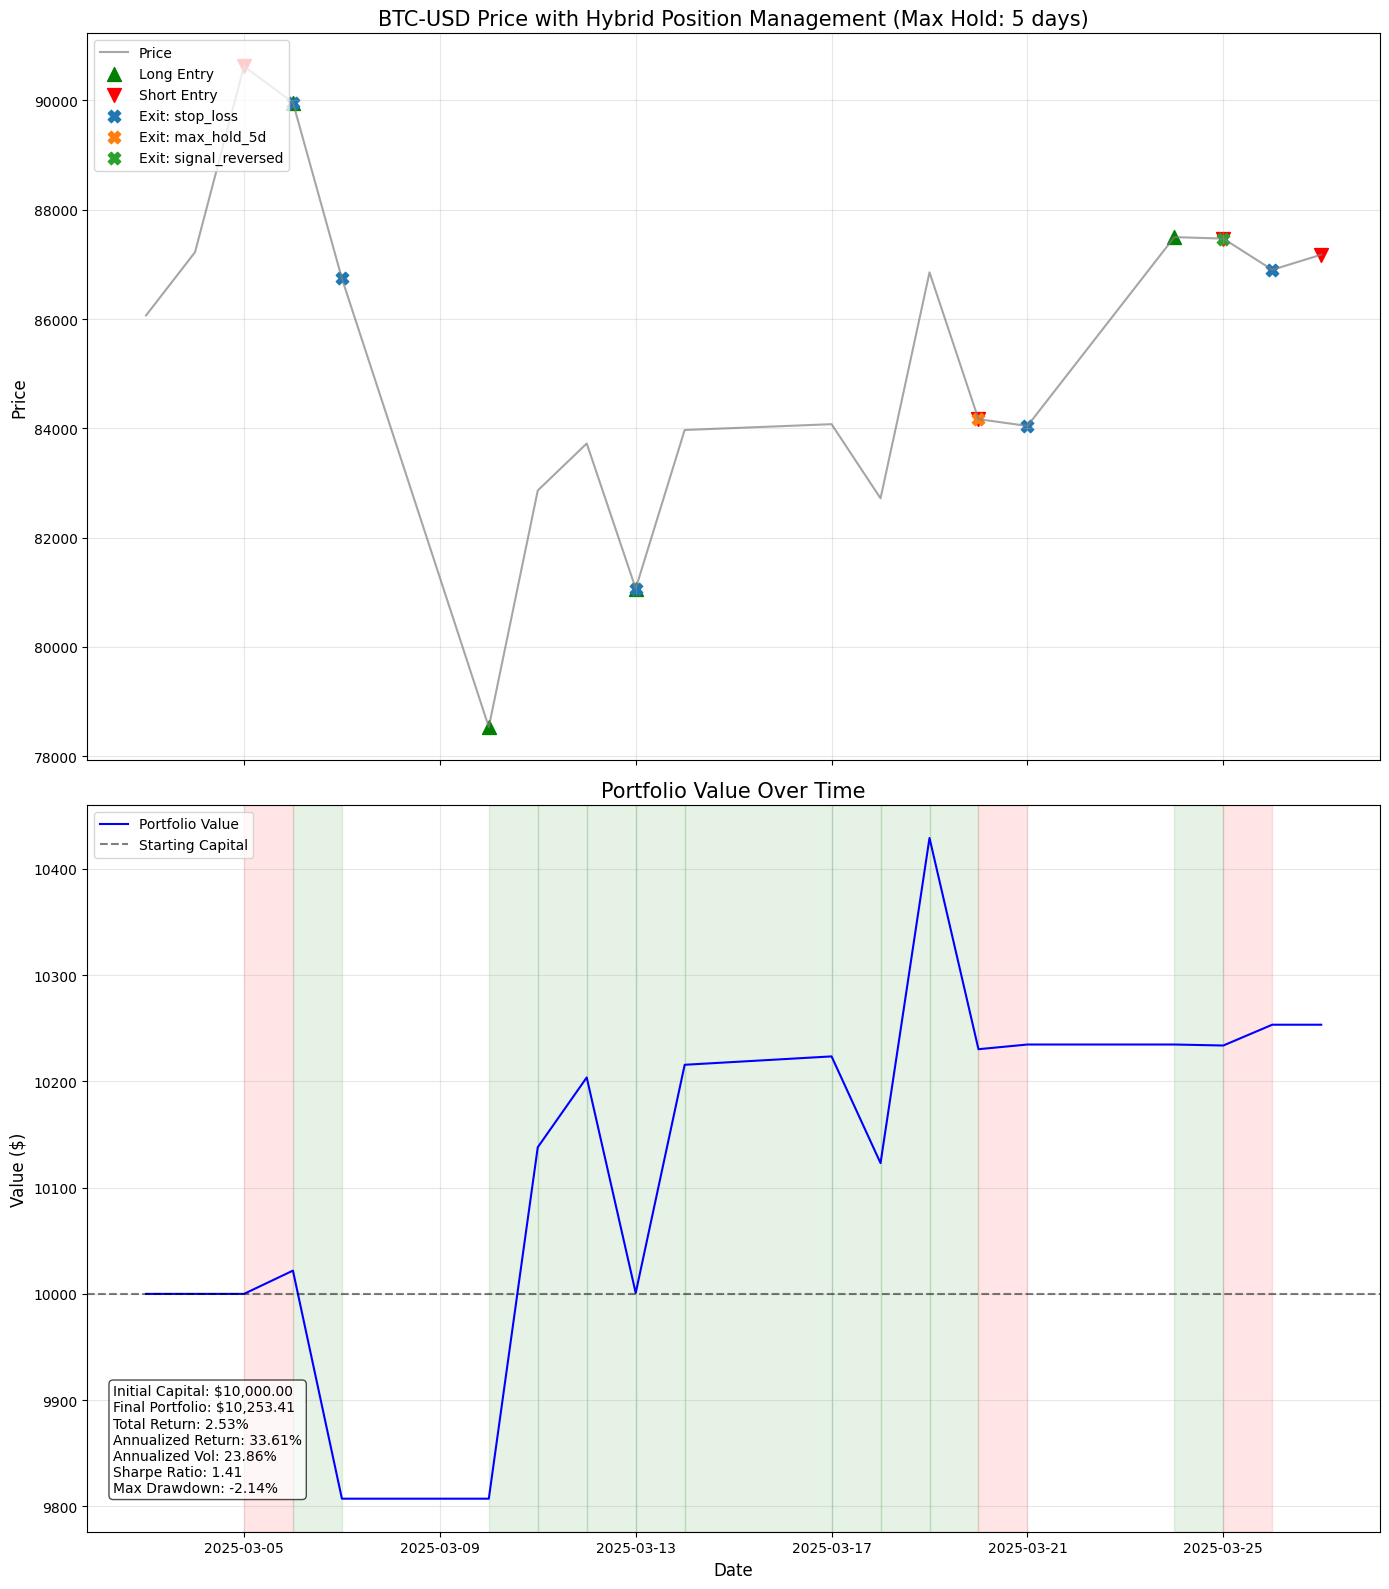

In [ ]:
BTC = backtest_hybrid_strategy_with_tuning(
    close_prices,           # Your historical price data
    'BTC-USD',              # The asset you want to trade
    max_hold_days=5,        # Maximum hold period of 5 days
    trailing_stop_pct=0.02)

Processing EUR/USD with automated hyperparameter tuning...
Engineering features...
Preparing data splits...
Tuning XGBoost hyperparameters...
Params: n_est=50, depth=3, lr=0.05 → F1 Score: 0.5455
Params: n_est=50, depth=3, lr=0.1 → F1 Score: 0.3684
Params: n_est=50, depth=3, lr=0.15 → F1 Score: 0.5778
Params: n_est=50, depth=5, lr=0.05 → F1 Score: 0.3333
Params: n_est=50, depth=5, lr=0.1 → F1 Score: 0.3902
Params: n_est=50, depth=5, lr=0.15 → F1 Score: 0.6047
Params: n_est=50, depth=7, lr=0.05 → F1 Score: 0.4211
Params: n_est=50, depth=7, lr=0.1 → F1 Score: 0.5238
Params: n_est=50, depth=7, lr=0.15 → F1 Score: 0.4865
Params: n_est=100, depth=3, lr=0.05 → F1 Score: 0.5366
Params: n_est=100, depth=3, lr=0.1 → F1 Score: 0.3889
Params: n_est=100, depth=3, lr=0.15 → F1 Score: 0.4878
Params: n_est=100, depth=5, lr=0.05 → F1 Score: 0.5116
Params: n_est=100, depth=5, lr=0.1 → F1 Score: 0.2703
Params: n_est=100, depth=5, lr=0.15 → F1 Score: 0.6222
Params: n_est=100, depth=7, lr=0.05 → F1 Score:

<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.65, Sell=0.33] → Return: 0.18%, Sharpe: 0.72, MaxDD: -0.34%
Thresholds [Buy=0.65, Sell=0.32] → Return: 0.33%, Sharpe: 1.42, MaxDD: -0.30%
Thresholds [Buy=0.65, Sell=0.31] → Return: 0.55%, Sharpe: 2.69, MaxDD: -0.30%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.65, Sell=0.3] → Return: 0.55%, Sharpe: 2.69, MaxDD: -0.30%
Thresholds [Buy=0.66, Sell=0.35] → Return: 0.39%, Sharpe: 1.50, MaxDD: -0.30%
Thresholds [Buy=0.66, Sell=0.34] → Return: 0.18%, Sharpe: 0.72, MaxDD: -0.34%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.66, Sell=0.33] → Return: 0.18%, Sharpe: 0.72, MaxDD: -0.34%
Thresholds [Buy=0.66, Sell=0.32] → Return: 0.33%, Sharpe: 1.42, MaxDD: -0.30%
Thresholds [Buy=0.66, Sell=0.31] → Return: 0.55%, Sharpe: 2.69, MaxDD: -0.30%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.66, Sell=0.3] → Return: 0.55%, Sharpe: 2.69, MaxDD: -0.30%
Thresholds [Buy=0.67, Sell=0.35] → Return: 0.33%, Sharpe: 1.27, MaxDD: -0.30%
Thresholds [Buy=0.67, Sell=0.34] → Return: 0.12%, Sharpe: 0.47, MaxDD: -0.40%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.67, Sell=0.33] → Return: 0.12%, Sharpe: 0.47, MaxDD: -0.40%
Thresholds [Buy=0.67, Sell=0.32] → Return: 0.27%, Sharpe: 1.16, MaxDD: -0.30%
Thresholds [Buy=0.67, Sell=0.31] → Return: 0.49%, Sharpe: 2.40, MaxDD: -0.30%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.67, Sell=0.3] → Return: 0.49%, Sharpe: 2.40, MaxDD: -0.30%
Thresholds [Buy=0.68, Sell=0.35] → Return: 0.40%, Sharpe: 1.56, MaxDD: -0.28%
Thresholds [Buy=0.68, Sell=0.34] → Return: 0.19%, Sharpe: 0.78, MaxDD: -0.40%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.68, Sell=0.33] → Return: 0.19%, Sharpe: 0.78, MaxDD: -0.40%
Thresholds [Buy=0.68, Sell=0.32] → Return: 0.34%, Sharpe: 1.50, MaxDD: -0.25%
Thresholds [Buy=0.68, Sell=0.31] → Return: 0.56%, Sharpe: 2.80, MaxDD: -0.23%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.68, Sell=0.3] → Return: 0.56%, Sharpe: 2.80, MaxDD: -0.23%
Thresholds [Buy=0.69, Sell=0.35] → Return: 0.32%, Sharpe: 1.25, MaxDD: -0.28%
Thresholds [Buy=0.69, Sell=0.34] → Return: 0.10%, Sharpe: 0.43, MaxDD: -0.49%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.69, Sell=0.33] → Return: 0.10%, Sharpe: 0.43, MaxDD: -0.49%
Thresholds [Buy=0.69, Sell=0.32] → Return: 0.25%, Sharpe: 1.14, MaxDD: -0.34%
Thresholds [Buy=0.69, Sell=0.31] → Return: 0.48%, Sharpe: 2.44, MaxDD: -0.23%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.69, Sell=0.3] → Return: 0.48%, Sharpe: 2.44, MaxDD: -0.23%
Thresholds [Buy=0.7, Sell=0.35] → Return: 0.32%, Sharpe: 1.25, MaxDD: -0.28%
Thresholds [Buy=0.7, Sell=0.34] → Return: 0.10%, Sharpe: 0.43, MaxDD: -0.49%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.7, Sell=0.33] → Return: 0.10%, Sharpe: 0.43, MaxDD: -0.49%
Thresholds [Buy=0.7, Sell=0.32] → Return: 0.25%, Sharpe: 1.14, MaxDD: -0.34%
Thresholds [Buy=0.7, Sell=0.31] → Return: 0.48%, Sharpe: 2.44, MaxDD: -0.23%


<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2976.4126258335687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9976.41262583357' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-in

Thresholds [Buy=0.7, Sell=0.3] → Return: 0.48%, Sharpe: 2.44, MaxDD: -0.23%

Best thresholds found: Buy=0.68, Sell=0.31
Best Sharpe ratio: 2.80
Generating trading signals with optimized thresholds...
Applying hybrid position management...
Calculating comprehensive performance metrics...

               KEY PERFORMANCE METRICS
Annual Return: 1.81%
Sharpe Ratio: 2.20
Max Drawdown: -0.14%
Annual Volatility: 0.82%
Number of Trades: 4
Profit per Trade: $3.41
Generating visualizations...


<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10011.706239573872' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10011.706239573872' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:130: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5985.832118433114' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'lowest_point'] = new_lowest
<ipython

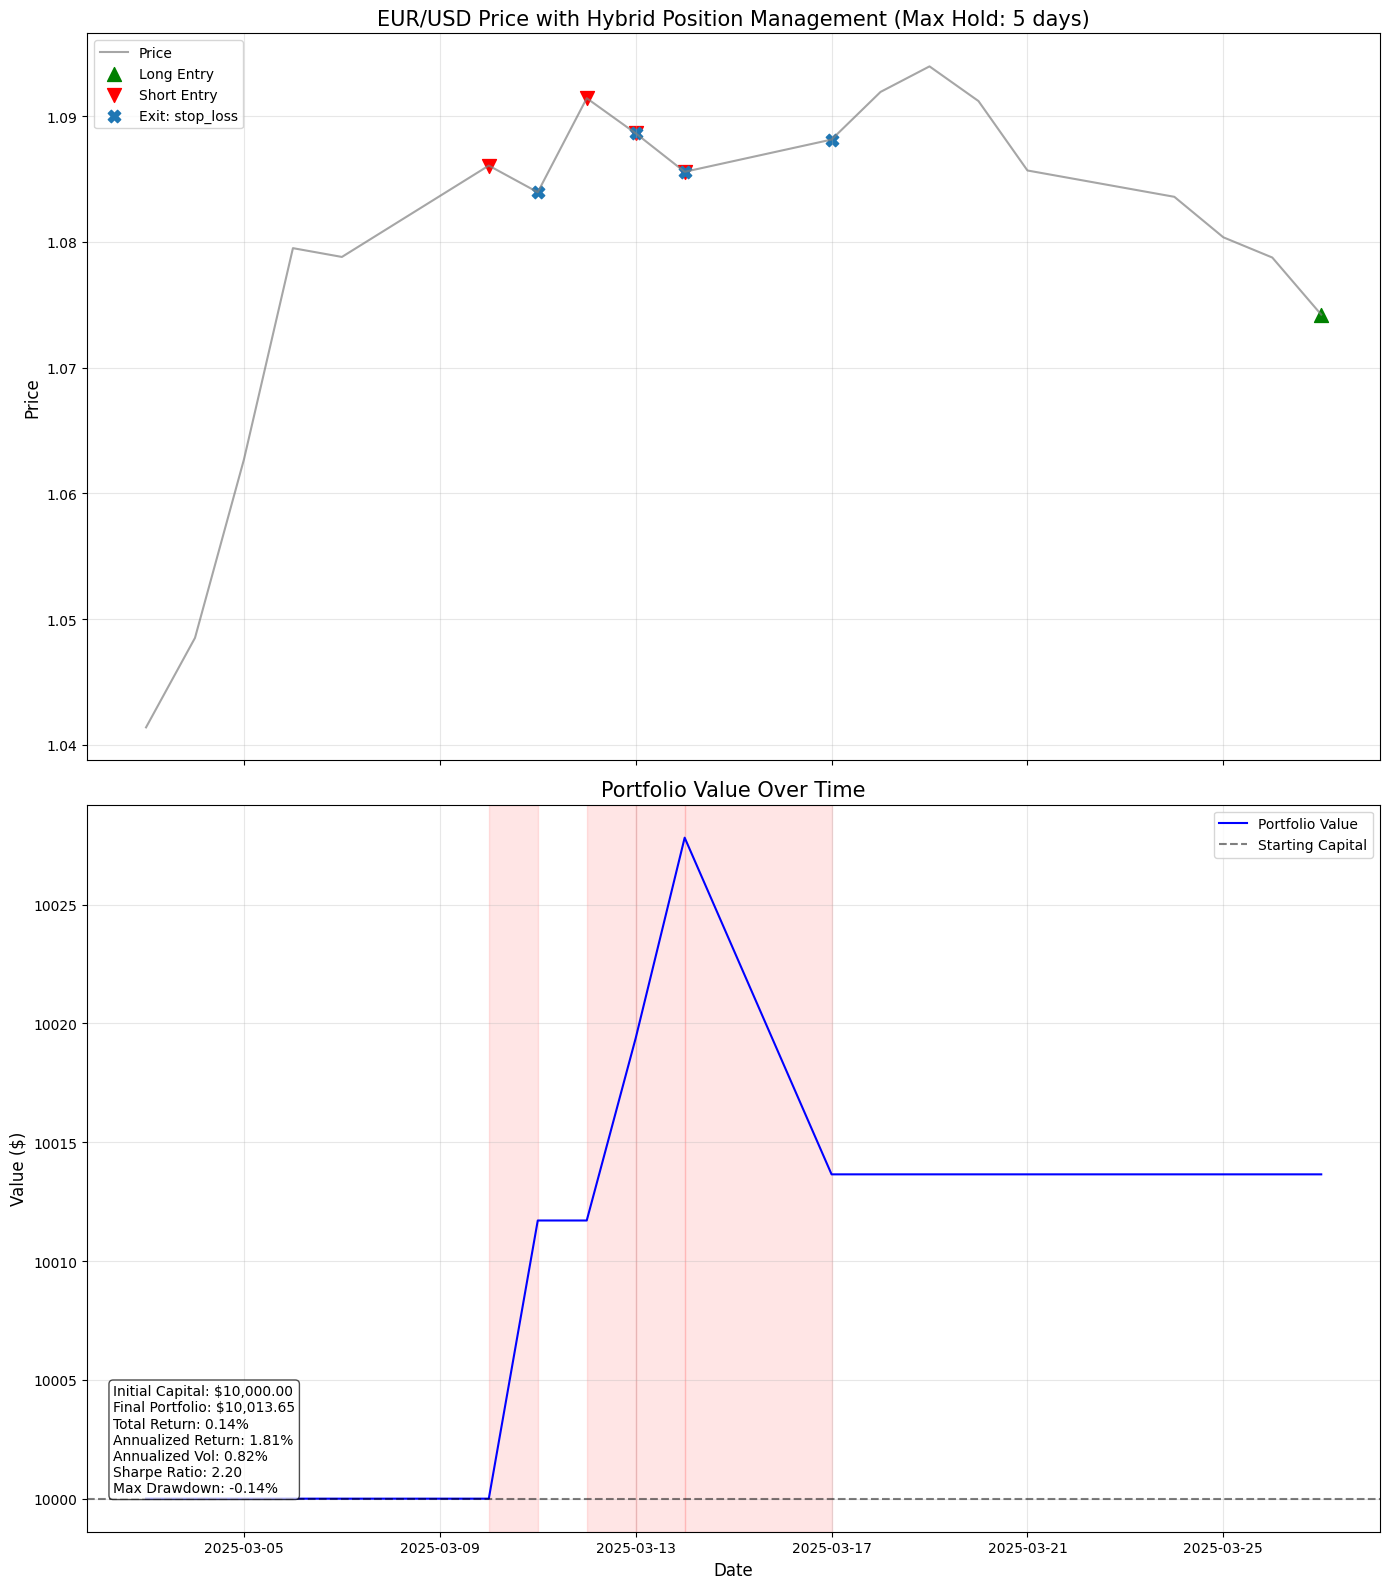

In [ ]:
EUR = backtest_hybrid_strategy_with_tuning(
    close_prices,           # Your historical price data
    'EUR/USD',              # The asset you want to trade
    max_hold_days=5,        # Maximum hold period of 5 days
    trailing_stop_pct=0.02)

Processing JPY/USD with automated hyperparameter tuning...
Engineering features...
Preparing data splits...
Tuning XGBoost hyperparameters...
Params: n_est=50, depth=3, lr=0.05 → F1 Score: 0.6316
Params: n_est=50, depth=3, lr=0.1 → F1 Score: 0.6897
Params: n_est=50, depth=3, lr=0.15 → F1 Score: 0.7302
Params: n_est=50, depth=5, lr=0.05 → F1 Score: 0.6545
Params: n_est=50, depth=5, lr=0.1 → F1 Score: 0.5385
Params: n_est=50, depth=5, lr=0.15 → F1 Score: 0.6552
Params: n_est=50, depth=7, lr=0.05 → F1 Score: 0.6296
Params: n_est=50, depth=7, lr=0.1 → F1 Score: 0.6071
Params: n_est=50, depth=7, lr=0.15 → F1 Score: 0.6429
Params: n_est=100, depth=3, lr=0.05 → F1 Score: 0.6667
Params: n_est=100, depth=3, lr=0.1 → F1 Score: 0.6552
Params: n_est=100, depth=3, lr=0.15 → F1 Score: 0.6774
Params: n_est=100, depth=5, lr=0.05 → F1 Score: 0.6667
Params: n_est=100, depth=5, lr=0.1 → F1 Score: 0.6429
Params: n_est=100, depth=5, lr=0.15 → F1 Score: 0.6552
Params: n_est=100, depth=7, lr=0.05 → F1 Score:

<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

Thresholds [Buy=0.65, Sell=0.32] → Return: 0.75%, Sharpe: 2.02, MaxDD: -0.60%
Thresholds [Buy=0.65, Sell=0.31] → Return: 0.75%, Sharpe: 2.02, MaxDD: -0.60%
Thresholds [Buy=0.65, Sell=0.3] → Return: 0.75%, Sharpe: 2.02, MaxDD: -0.60%


<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

Thresholds [Buy=0.66, Sell=0.35] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.66, Sell=0.34] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.66, Sell=0.33] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.66, Sell=0.32] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%


<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

Thresholds [Buy=0.66, Sell=0.31] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.66, Sell=0.3] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.67, Sell=0.35] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.67, Sell=0.34] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%


<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

Thresholds [Buy=0.67, Sell=0.33] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.67, Sell=0.32] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.67, Sell=0.31] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.67, Sell=0.3] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%


<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9992.89019817058' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<i

Thresholds [Buy=0.68, Sell=0.35] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.68, Sell=0.34] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.68, Sell=0.33] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.68, Sell=0.32] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%


<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

Thresholds [Buy=0.68, Sell=0.31] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.68, Sell=0.3] → Return: 0.94%, Sharpe: 2.63, MaxDD: -0.60%
Thresholds [Buy=0.69, Sell=0.35] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.69, Sell=0.34] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%


<ipython-input-131-ff7c60540dde>:191: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9992.89019817058' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'cash'] = new_cash
<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<i

Thresholds [Buy=0.69, Sell=0.33] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.69, Sell=0.32] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.69, Sell=0.31] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.69, Sell=0.3] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%


<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

Thresholds [Buy=0.7, Sell=0.35] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.7, Sell=0.34] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.7, Sell=0.33] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%


<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

Thresholds [Buy=0.7, Sell=0.32] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.7, Sell=0.31] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%
Thresholds [Buy=0.7, Sell=0.3] → Return: -0.14%, Sharpe: -0.43, MaxDD: -0.82%

Best thresholds found: Buy=0.66, Sell=0.35
Best Sharpe ratio: 2.63
Generating trading signals with optimized thresholds...
Applying hybrid position management...
Calculating comprehensive performance metrics...

               KEY PERFORMANCE METRICS
Annual Return: 0.43%
Sharpe Ratio: 0.42
Max Drawdown: -0.25%
Annual Volatility: 1.01%
Number of Trades: 1
Profit per Trade: $3.22
Generating visualizations...


<ipython-input-131-ff7c60540dde>:192: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2987.464387184929' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'position_value'] = new_position_value
<ipython-input-131-ff7c60540dde>:193: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9987.46438718493' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'portfolio_value'] = new_cash + new_position_value
<ipython-input-131-ff7c60540dde>:119: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3015.808155758731' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals.loc[curr_idx, 'highest_point'] = n

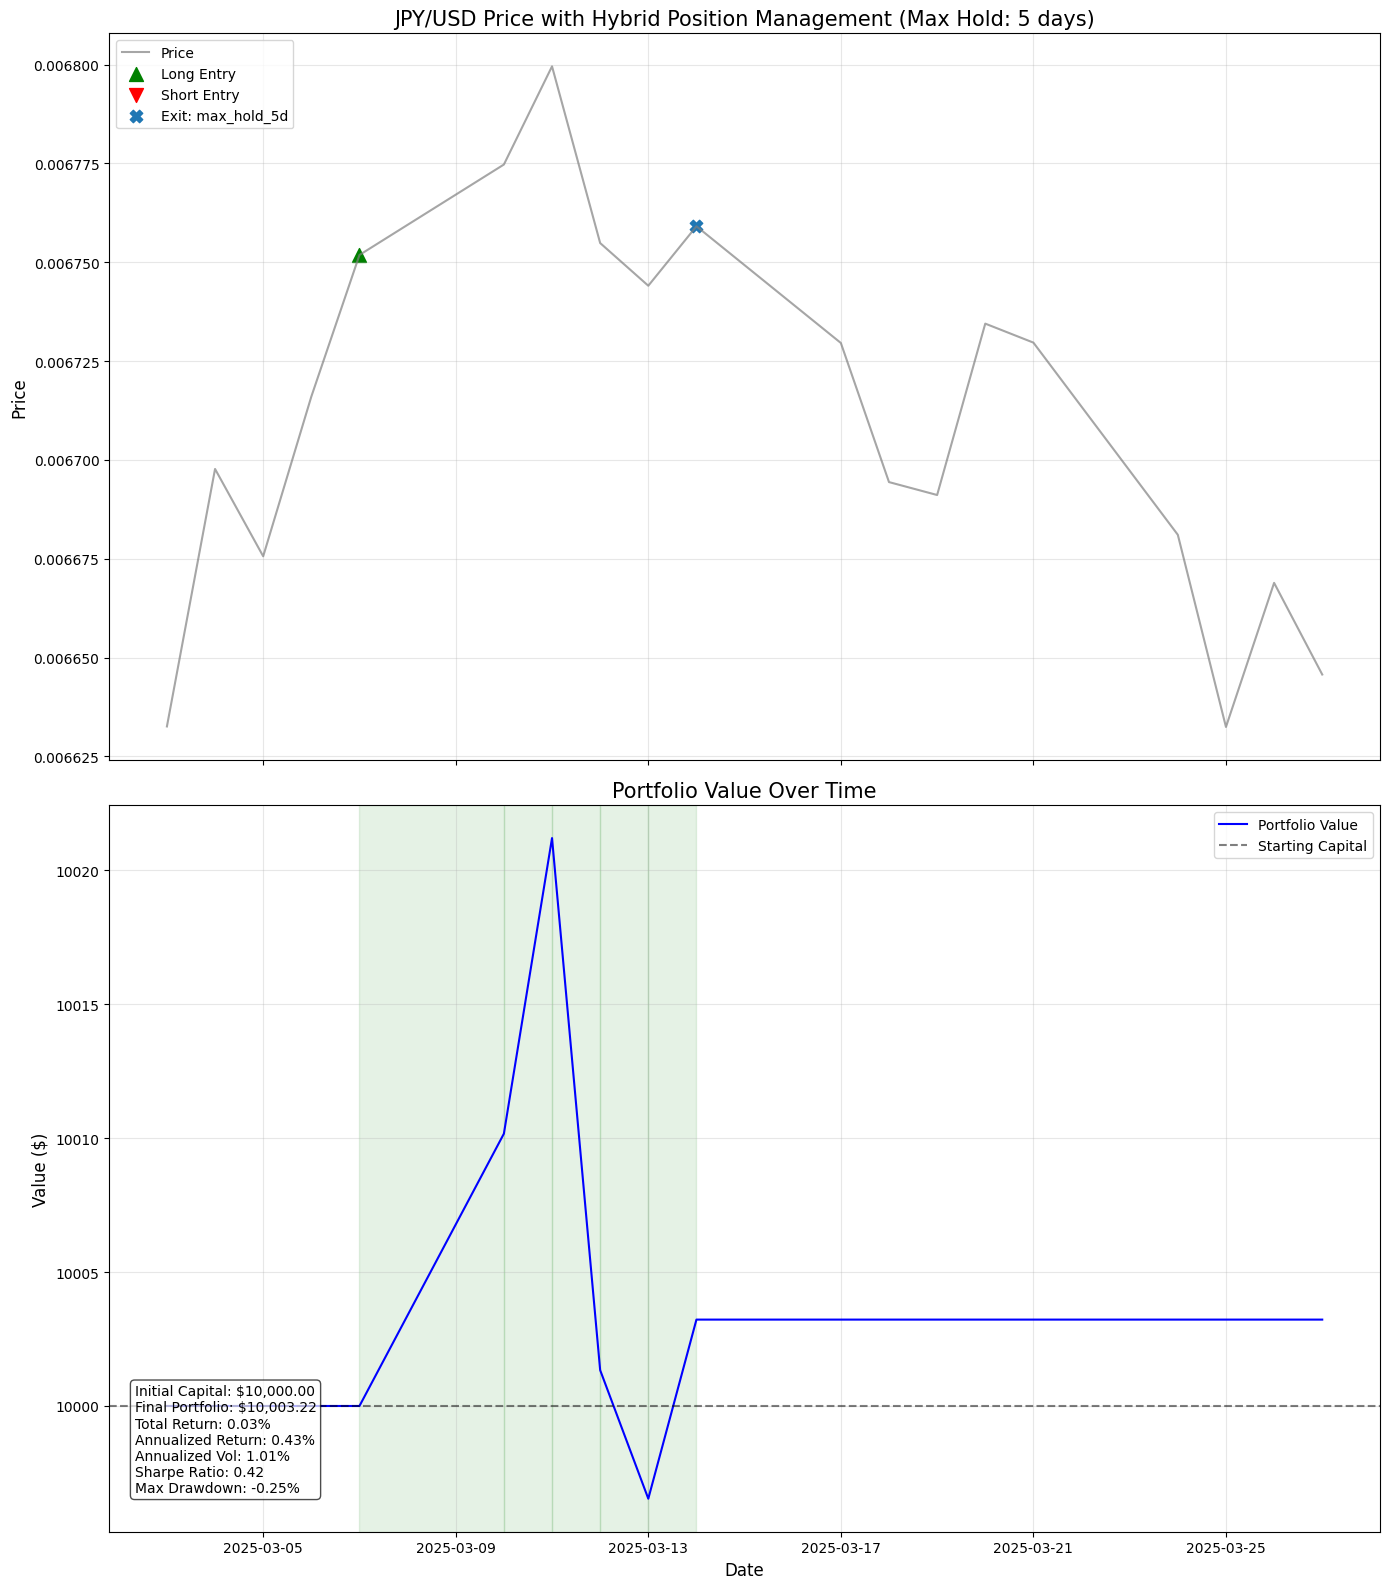

In [ ]:
JPY = backtest_hybrid_strategy_with_tuning(
    close_prices,           # Your historical price data
    'JPY/USD',              # The asset you want to trade
    max_hold_days=5,        # Maximum hold period of 5 days
    trailing_stop_pct=0.02)  # 2% trailing stop

In [ ]:
def plot_total_portfolio(BTC, ETH, JPY, EUR, per_asset_capital=10000, equal_weight=True):
    """
    Creates a line plot of total portfolio value.
    Each asset starts with per_asset_capital, even in equal weighting.
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    total_capital = per_asset_capital * 4  # always 4 assets
    asset_capital = per_asset_capital

    # Portfolio values (no scaling needed, as each portfolio starts from 10k)
    btc_portfolio = BTC['signals']['portfolio_value']
    eth_portfolio = ETH['signals']['portfolio_value']
    jpy_portfolio = JPY['signals']['portfolio_value']
    eur_portfolio = EUR['signals']['portfolio_value']

    # If equal_weight, scale each asset to reflect equal share of total portfolio
    if equal_weight:
        # Normalize returns to start at 1, then multiply by per_asset_capital
        btc_portfolio = (btc_portfolio / btc_portfolio.iloc[0]) * per_asset_capital
        eth_portfolio = (eth_portfolio / eth_portfolio.iloc[0]) * per_asset_capital
        jpy_portfolio = (jpy_portfolio / jpy_portfolio.iloc[0]) * per_asset_capital
        eur_portfolio = (eur_portfolio / eur_portfolio.iloc[0]) * per_asset_capital

    # Combine into one DataFrame
    all_dates = sorted(set(btc_portfolio.index) | set(eth_portfolio.index) |
                       set(jpy_portfolio.index) | set(eur_portfolio.index))
    combined = pd.DataFrame(index=all_dates)

    combined['BTC'] = btc_portfolio
    combined['ETH'] = eth_portfolio
    combined['JPY'] = jpy_portfolio
    combined['EUR'] = eur_portfolio

    # Fill missing values and calculate total
    combined = combined.fillna(method='ffill').fillna(asset_capital)
    combined['Total'] = combined.sum(axis=1)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(combined.index, combined['Total'], linewidth=2.5, color='blue')
    plt.axhline(y=total_capital, color='red', linestyle='--', alpha=0.7)

    # Performance
    final_value = combined['Total'].iloc[-1]
    total_return = (final_value / total_capital - 1) * 100

    plt.title(f'Total Portfolio Value (Return: {total_return:.2f}%)', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Portfolio Value ($)', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(['Portfolio', 'Initial Capital'], loc='upper left')
    plt.tight_layout()
    plt.show()

    return combined


<ipython-input-138-f54854a9befa>:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined = combined.fillna(method='ffill').fillna(asset_capital)


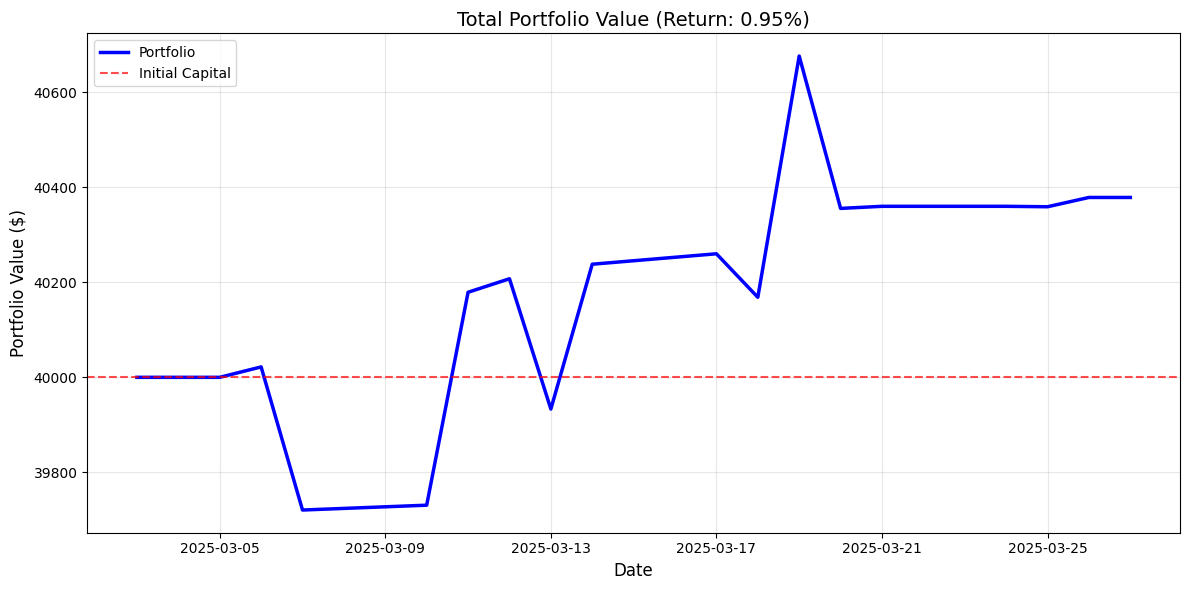

In [ ]:
total_portfolio = plot_total_portfolio(BTC, ETH, JPY, EUR, per_asset_capital=10000)